<a href="https://colab.research.google.com/github/Kushagratandon12/Weed_Detection/blob/main/WEED_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALLING THE DATASET- DEEP WEEDX


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d coreylammie/deepweedsx
!unzip '/content/deepweedsx.zip'


In [8]:
##IMPORTANT IMPORT'S REQUIRED FOR THE CODE
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import ImageFile
from tensorflow import keras 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import ResNet50V2,InceptionV3,MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,MaxPooling2D

# UNDERSTANDING THE DATASET

In [ ]:
train_df = pd.read_csv('/content/train_set_labels.csv', delimiter=',')
train_df.head()

0- Chinee Apple
1- Lantana
2- Parkinsonia
3- Parthenium
4- Prickly Acacia
5- Rubber Vine
6- Siam Weed
7- Snake Weed
8- Other

In [ ]:
train_df['Species_Name'] = train_df['Species'].map({0:'Chinee Apple',1:'Lantana',2:'Parkinsonia',3:'Parthenium',4:'Prickly Acacia',5:'Rubber Vine',6:'Siam Weed',7:'Snake Weed',8:'Other'})

In [ ]:
#Total Number Of Species We Have In Our Dataset
train_df.groupby(['Species']).count()

# Analyzing The Images In The Dataset For Different Species

In [ ]:
file_name = train_df['Label']
file_name = shuffle(file_name)
file_name = file_name.reset_index()
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(3,3,i+1)
    img = plt.imread('/content/DeepWeeds_Images_256/'+file_name['Label'][i])
    plt.imshow(img/255,aspect='auto')

# **SHOWING WHAT IMAGE AGUMENTATION DO*

In [ ]:

# # Importing necessary functions 
# from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 
   
# # Initialising the ImageDataGenerator class. 
# # We will pass in the augmentation parameters in the constructor. 
# datagen = ImageDataGenerator( 
#         rescale=1./255,
#         rotation_range = 30, 
#         shear_range = 0.2, 
#         zoom_range = 0.2,
#         brightness_range=[1.5,1.9],
#         horizontal_flip = True,) 

# # Loading a sample image  
# img = load_img('/content/DeepWeeds_Images_256/20161207-110730-0.jpg')  
# # Converting the input sample image to an array 
# x = img_to_array(img) 
# # Reshaping the input image 
# x = x.reshape((1, ) + x.shape)  
   
# # Generating and saving 7 augmented samples  
# # using the above defined parameters.  
# i = 0
# for batch in datagen.flow(x, batch_size = 1, 
#                           save_to_dir ='/content/',  
#                           save_prefix ='image', save_format ='jpeg'): 
#     i += 1
#     if i > 5: 
#         break

# Agumentation USING IMAGE DATA GENERTAOR OF TENSORFLOW 

In [ ]:
train_gen= ImageDataGenerator(rescale=1./255,
                                 rotation_range=20,
                                 zoom_range=0.5,
                                 brightness_range=[1.5,1.9],
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)

train_generator=train_gen.flow_from_dataframe( 
                                            dataframe=train_df,
                                            directory="/content/DeepWeeds_Images_256",
                                            x_col="Label",
                                            y_col="Species_Name",
                                            # batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='categorical',
                                            target_size=(256,256)
                                            )

Found 15007 validated image filenames belonging to 9 classes.


In [ ]:
CLASS_NAMES = ['Chinee Apple',
'Lantana',
'Parkinsonia',
'Parthenium',
'Prickly Acacia',
'Rubber Vine',
'Siam Weed',
'Snake Weed',
'Other']

print(len(CLASS_NAMES))

9


**Validation / Testing Dataset Extraction**

In [ ]:
test_df = pd.read_csv('/content/train_set_labels.csv')
test_df['Species_Name'] = test_df['Species'].map({0:'Chinee Apple',1:'Lantana',2:'Parkinsonia',3:'Parthenium',4:'Prickly Acacia',5:'Rubber Vine',6:'Siam Weed',7:'Snake Weed',8:'Other'})

(256, 256, 3)


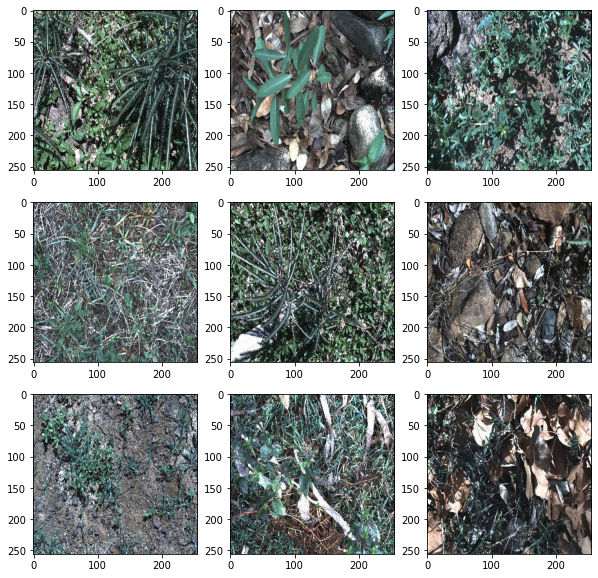

In [ ]:
file_name = test_df['Label']
file_name = shuffle(file_name)
file_name = file_name.reset_index()
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(3,3,i+1)
    img = plt.imread('/content/DeepWeeds_Images_256/'+file_name['Label'][i])
    plt.imshow(img/255,aspect='auto')

print(img.shape)

Image Data Generator For Validation Dataset

In [ ]:
validation_gen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_gen.flow_from_dataframe(
                                            dataframe=test_df,
                                            directory="/content/deepweeds_images_256",
                                            x_col="Label",
                                            y_col="Species_Name",
                                            # batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='categorical',
                                            target_size=(256,256))

Found 15007 validated image filenames belonging to 9 classes.


# Model Building 

In [ ]:
#Balancing the Class Weights Of All The Classes Since They Are Inbalanced 
from sklearn.utils import compute_class_weight
classweights = compute_class_weight('balanced',np.unique(train_generator.labels),train_generator.labels) 
Classweight= {}
for i,weight in enumerate(classweights):
    Classweight[i]=weight
print(Classweight)
#Changing the optimizer 
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

**Function For Transfer Learning Model **

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
def define_model(n_layers=150,BASE_MODEL='ResNet50V2'):
    if BASE_MODEL =='ResNet50V2':
        # Pre-trained model with MobileNetV2
        base_model = ResNet50V2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=True
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.2)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    
    if BASE_MODEL =='InceptionV3':
        base_model = InceptionV3(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=False
        
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.5)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)


    if BASE_MODEL =='MobileNetV2':
        base_model = MobileNetV2(input_shape=(256,256,3),include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=True
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.5)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)    
    return model

# define Model 
model= define_model(BASE_MODEL='ResNet50V2')

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=SGD(lr=0.01), 
    metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [ ]:
epochs=10
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath='Model_Weights_ResNet50',monitor='val_accuracy', verbose= 1 ,save_best_only=True)
callbacks_list = [checkpoint,reduce_lr_loss]
history=model.fit(train_generator,epochs=epochs,
                  validation_data=validation_generator,
                  callbacks=callbacks_list)

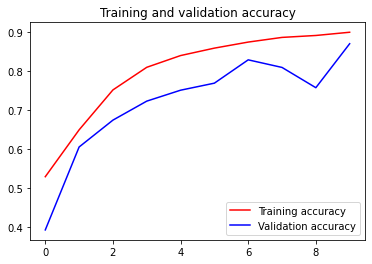

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

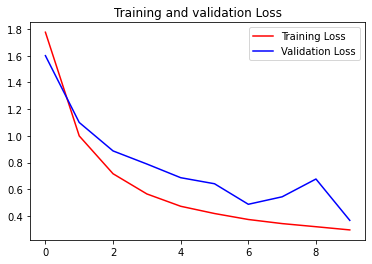

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
saved_model = load_model('/content/Model_Weights_ResNet50')

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float16)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [ ]:
import cv2
original = cv2.imread(image_path)
orig = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
orig = cv2.resize(orig,(256,256))

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # resize the heatmap to oringnal X-Ray image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

In [ ]:
img = tf.io.read_file(image_path)  
img = decode_img(img)
img = np.expand_dims(img.numpy(), axis=0)
print (img.shape)
idx = np.argmax(saved_model.predict(img))
CLASS_NAMES[idx]

(1, 256, 256, 3)


'Lantana'

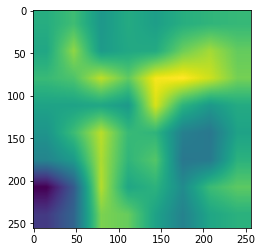

In [ ]:
cam = GradCAM(model=model, classIdx=idx, layerName='conv5_block3_3_conv') 
heatmap = cam.compute_heatmap(img)
plt.imshow(heatmap)
plt.show()

(256, 256)
256 256


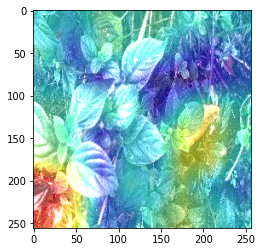

In [ ]:
def get_mapped_img(heatmap,original_img,intensity = 0.5):
  # Old fashioned way to overlay a transparent heatmap onto original image, the same as above
  heatmapY = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
  heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_JET) 
  imageY = cv2.addWeighted(heatmapY, intensity, original_img, 1.0, 0)
  return imageY
print(heatmap.shape)
print(orig.shape[1],orig.shape[0])
plt.imshow(get_mapped_img(heatmap,orig))

# Object Detection 

In [ ]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !rm -rf /content/sample_data
# !unzip /content/crop-and-weed-detection-data-with-bounding-boxes.zip
# !rm -rf /content/crop-and-weed-detection-data-with-bounding-boxes.zip


In [5]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet/

Cloning into 'darknet'...
remote: Enumerating objects: 15072, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15072 (delta 0), reused 1 (delta 0), pack-reused 15069
Receiving objects: 100% (15072/15072), 13.43 MiB | 16.30 MiB/s, done.
Resolving deltas: 100% (10243/10243), done.
/content/darknet


In [ ]:
# %cd data
# !kaggle datasets download -d ravirajsinh45/crop-and-weed-detection-data-with-bounding-boxes
!unzip /content/darknet/data/crop-and-weed-detection-data-with-bounding-boxes.zip
!rm -rf /content/darknet/data/crop-and-weed-detection-data-with-bounding-boxes.zip

In [14]:
data_select = glob.glob('/content/darknet/data/agri_data/data/*.jpeg')
train_txt = open("train.txt", "w")
for file_txt in data_select:
  train_txt.write(file_txt)
  train_txt.write('\n')

data_select = glob.glob('/content/darknet/data/agri_data/data/*jpeg')
random.shuffle(data_select)
test_txt = open("test.txt", "w")
for file_txt in data_select:
  test_txt.write(file_txt)
  test_txt.write('\n')

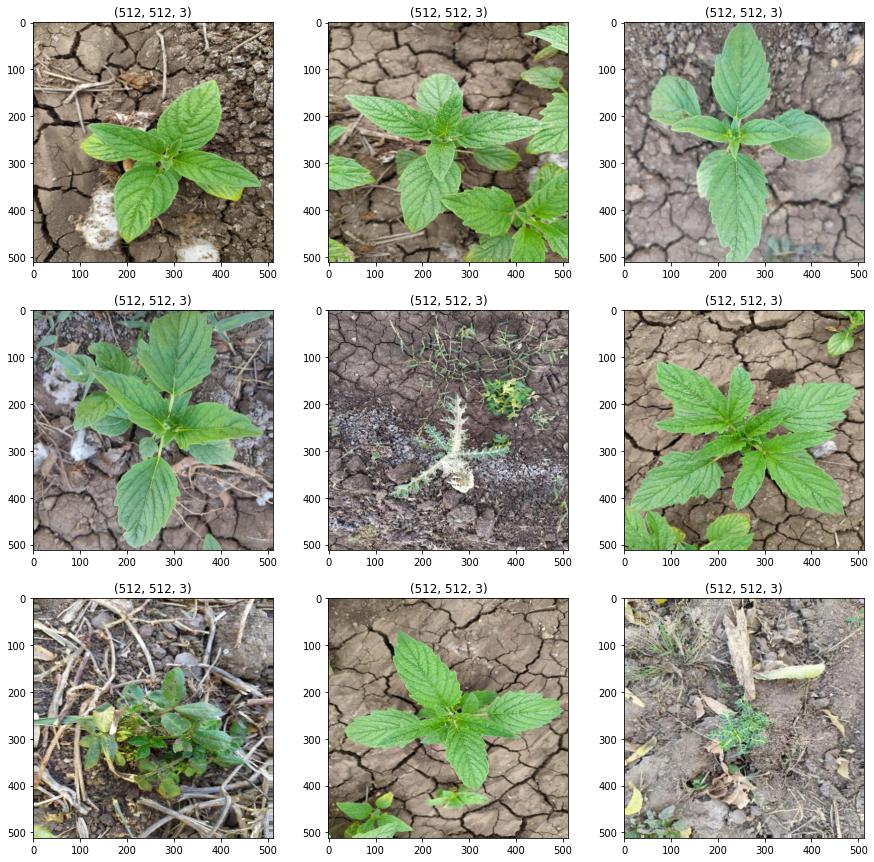

In [15]:
image_select = glob.glob('/content/darknet/data/agri_data/data/*.jpeg')
random.shuffle(image_select)
plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3,3,i+1)
  img = plt.imread(image_select[i])
  plt.title(img.shape)
  plt.imshow(img)

In [ ]:
%cd ..
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
!cp /content/darknet/cfg/yolov4-custom.cfg /content/

In [ ]:
!make -j4

In [18]:
from google.colab import drive
drive.mount('MyDrive')

Mounted at MyDrive


In [ ]:
! /content/darknet/darknet detector train /content/darknet/data/obj.data /content/yolov4-custom.cfg /content/darknet/yolov4.conv.137 -dont_show  -map

Streaming output truncated to the last 5000 lines.
 total_bbox = 5256, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.270821), count: 13, class_loss = 3997.663818, iou_loss = 6.097656, total_loss = 4003.761475 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.428151), count: 22, class_loss = 1070.707275, iou_loss = 4.512939, total_loss = 1075.220215 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.463477), count: 10, class_loss = 258.506775, iou_loss = 0.171814, total_loss = 258.678589 
 total_bbox = 5301, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.416120), count: 1, class_loss = 3991.350830, iou_loss = 0.458008, total_loss = 3991.808838 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.392044), count: 22, class_loss = 1072.353638, iou_loss = 3.044922, 